# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

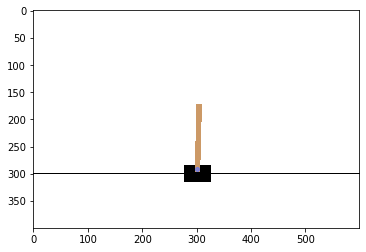

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [0]:
import torch
import torch.nn as nn

In [0]:
model = nn.Sequential(
  nn.Linear(4,200),
  nn.Sigmoid(),
  nn.Linear(200,2)
)

#### Predict function

In [0]:
def predict_probs(states):
    # convert states, compute logits, use softmax to get probability
    logits = model(torch.as_tensor(states, dtype = torch.float32))
    return torch.softmax(logits, dim=1).detach().numpy()

### Play the game

We can now use our newly built agent to play the game.

In [0]:
import random

In [0]:
def generate_session(t_max=1000):
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]
  
        # Sample action with given probabilities.
        r = random.random()
        if r>action_probs[0]:
            a = 1
        else:
            a = 0
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [0]:
# test it
states, actions, rewards = generate_session()

### Computing cumulative rewards

In [0]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    
    G = []
    total_reward = 0
    coefficient = 1
    rewards.reverse()
    for r in rewards:
      total_reward = total_reward*gamma + r
      G.append(total_reward)
    G.reverse()
    return G

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [0]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [0]:

optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):


    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    loss = -torch.mean(log_probs_for_actions * cumulative_returns)

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [25]:
for i in range(100):
    rewards = [train_on_session(*generate_session())
               for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    if np.mean(rewards) > 500:
        print("You Win!")  
        break

mean reward:64.900
mean reward:39.470
mean reward:48.320
mean reward:55.680
mean reward:73.330
mean reward:69.510
mean reward:122.760
mean reward:65.150
mean reward:163.360
mean reward:155.090
mean reward:279.850
mean reward:265.900
mean reward:290.180
mean reward:436.530
mean reward:346.160
mean reward:308.660
mean reward:368.200
mean reward:437.410
mean reward:265.330
mean reward:302.460
mean reward:103.110
mean reward:351.930
mean reward:608.510
You Win!
